# Imports


In [18]:
!pip install plotly

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import plotly.graph_objects as go

# Load data

In [2]:
df = pd.read_csv("comments_with_sentiment.csv")

df["video_published_at"] = pd.to_datetime(df["video_published_at"]).dt.date
df["year"] = pd.to_datetime(df["video_published_at"]).dt.year

df = df.dropna(subset=["sentiment_toward_ukraine"])

In [3]:
df

,id,video_title,video_published_at,comment,stance_label,continuous_sentiment,sentiment_toward_ukraine,year
0,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Get Russia out of Ukraine Now,prorussian,-0.6330,-0.632812,2023
1,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,The West needs to immediately provide Ukraine ...,prorussian,-0.6110,-0.610840,2023
2,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Rules Based 💩(order). You tell us Russia is we...,prorussian,-0.8887,-0.888672,2023
3,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,Instead of feeding poor people in America we s...,proukrainian,-0.8813,-0.881348,2023
4,VLjlMo2EF8s,Retired colonel says this factor gives an adva...,2023-02-19,CNN is the king of that retired US military. A...,prorussian,-0.5260,0.525879,2023
...,...,...,...,...,...,...,...,...
1554322,rXcJZAdcvjw,Putin vows Russia will seize Donbas region by ...,2025-12-04,It should finally dawn on even the dumbest peo...,prorussian,-0.8880,-0.888184,2025
1554323,rXcJZAdcvjw,Putin vows Russia will seize Donbas region by ...,2025-12-04,"Mr. TACO ""I will end this war in 24 hours""",neutral,-0.1918,0.000000,2025
1554324,rXcJZAdcvjw,Putin vows Russia will seize Donbas region by ...,2025-12-04,Bring down 25 tall buildings in moscow..get th...,prorussian,-0.4907,0.490723,2025
1554325,rXcJZAdcvjw,Putin vows Russia will seize Donbas region by ...,2025-12-04,Why so many vatniks are here -dumbs :Americans...,prorussian,0.8735,0.873535,2025


# Prepare daily sentiment

In [7]:
daily = (
    df.groupby("video_published_at")["sentiment_toward_ukraine"]
      .mean()
      .reset_index()
      .rename(columns={"sentiment_toward_ukraine": "daily_sentiment"})
)

daily["video_published_at"] = pd.to_datetime(daily["video_published_at"])

daily = daily.sort_values("video_published_at").reset_index(drop=True)

daily["smooth_sentiment"] = (
    daily["daily_sentiment"]
    .rolling(window=7, center=True, min_periods=1)
    .mean()
)

daily["year"] = daily["video_published_at"].dt.year

In [8]:
daily

,video_published_at,daily_sentiment,smooth_sentiment,year
0,2023-02-19,-0.083915,-0.019232,2023
1,2023-02-20,-0.030454,-0.019775,2023
2,2023-02-21,0.024453,-0.016382,2023
3,2023-02-22,0.012989,-0.013309,2023
4,2023-02-23,-0.021945,0.017201,2023
...,...,...,...,...
652,2025-11-29,-0.096897,-0.036722,2025
653,2025-12-01,-0.089057,-0.023342,2025
654,2025-12-02,-0.042794,-0.013440,2025
655,2025-12-03,0.039756,-0.029722,2025


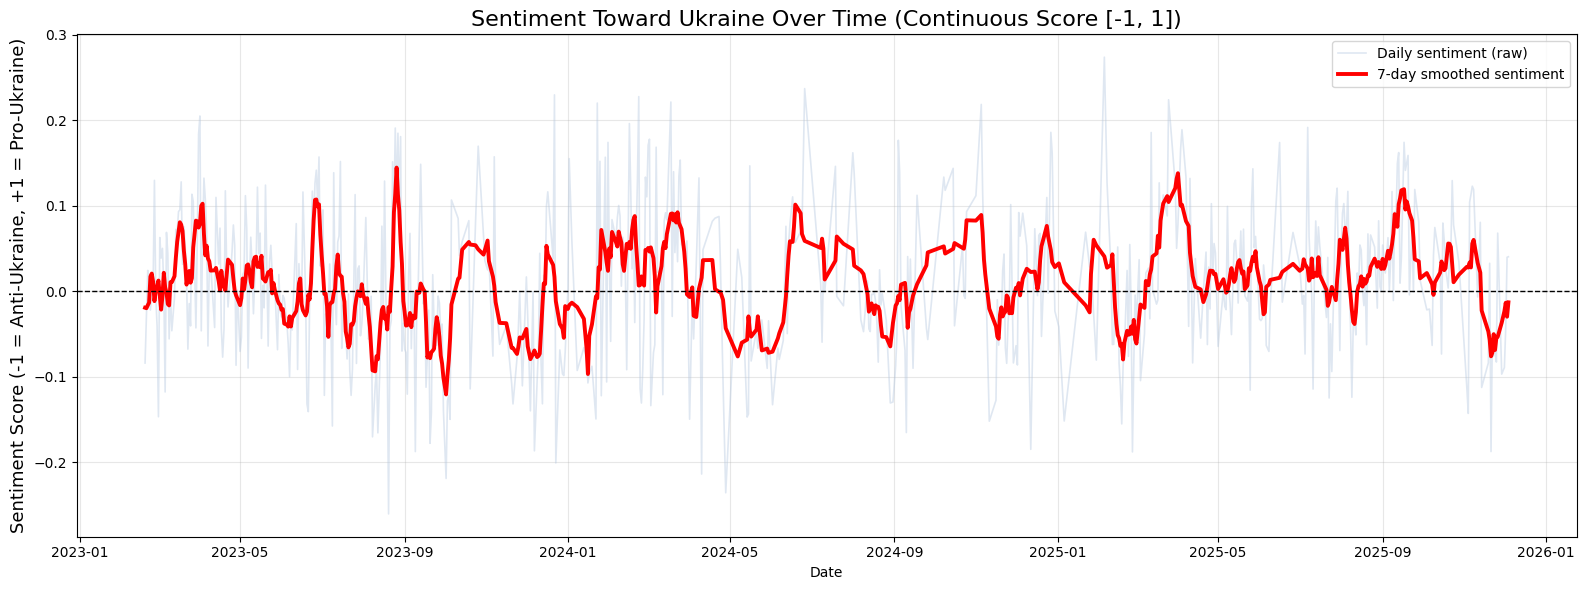

In [9]:
plt.figure(figsize=(16, 6))

plt.plot(
    daily["video_published_at"],
    daily["daily_sentiment"],
    color="lightsteelblue",
    alpha=0.4,
    linewidth=1.2,
    label="Daily sentiment (raw)"
)

plt.plot(
    daily["video_published_at"],
    daily["smooth_sentiment"],
    color="red",
    linewidth=2.8,
    label="7-day smoothed sentiment"
)

plt.axhline(0, linestyle="--", color="black", linewidth=1)

plt.title("Sentiment Toward Ukraine Over Time (Continuous Score [-1, 1])", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)", fontsize=13)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

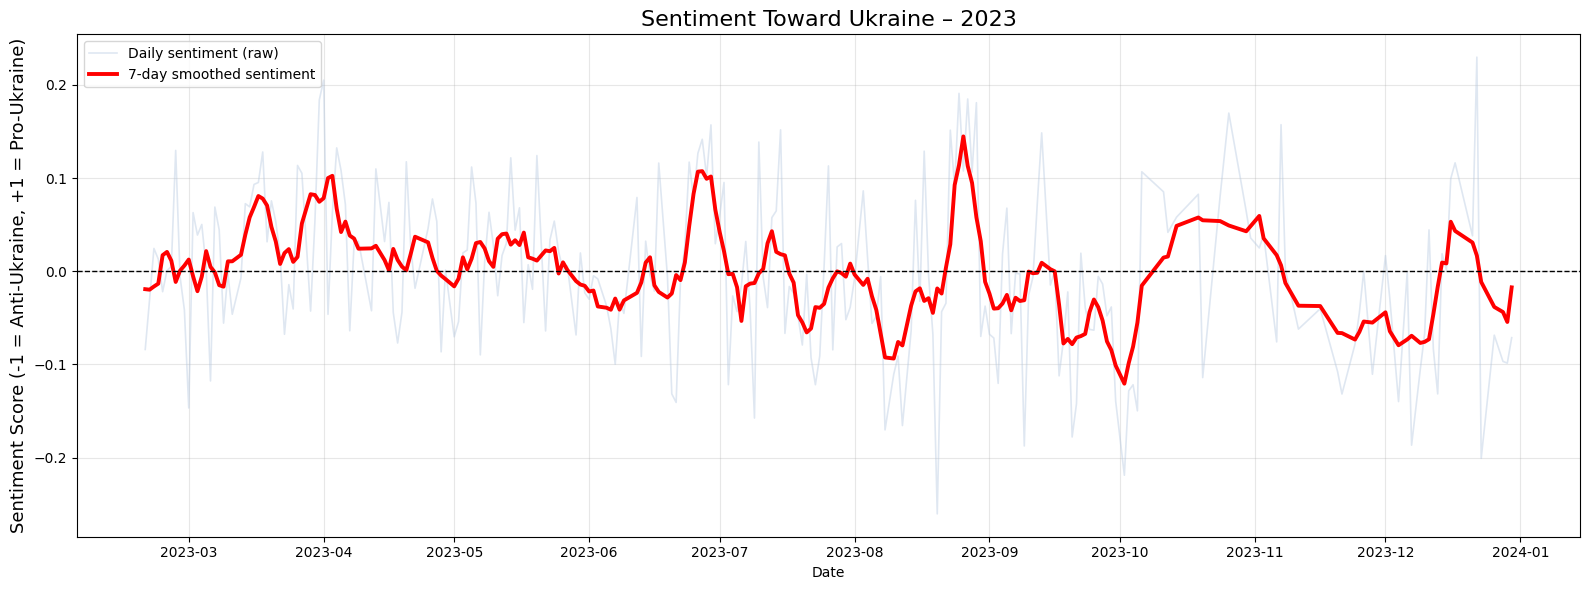

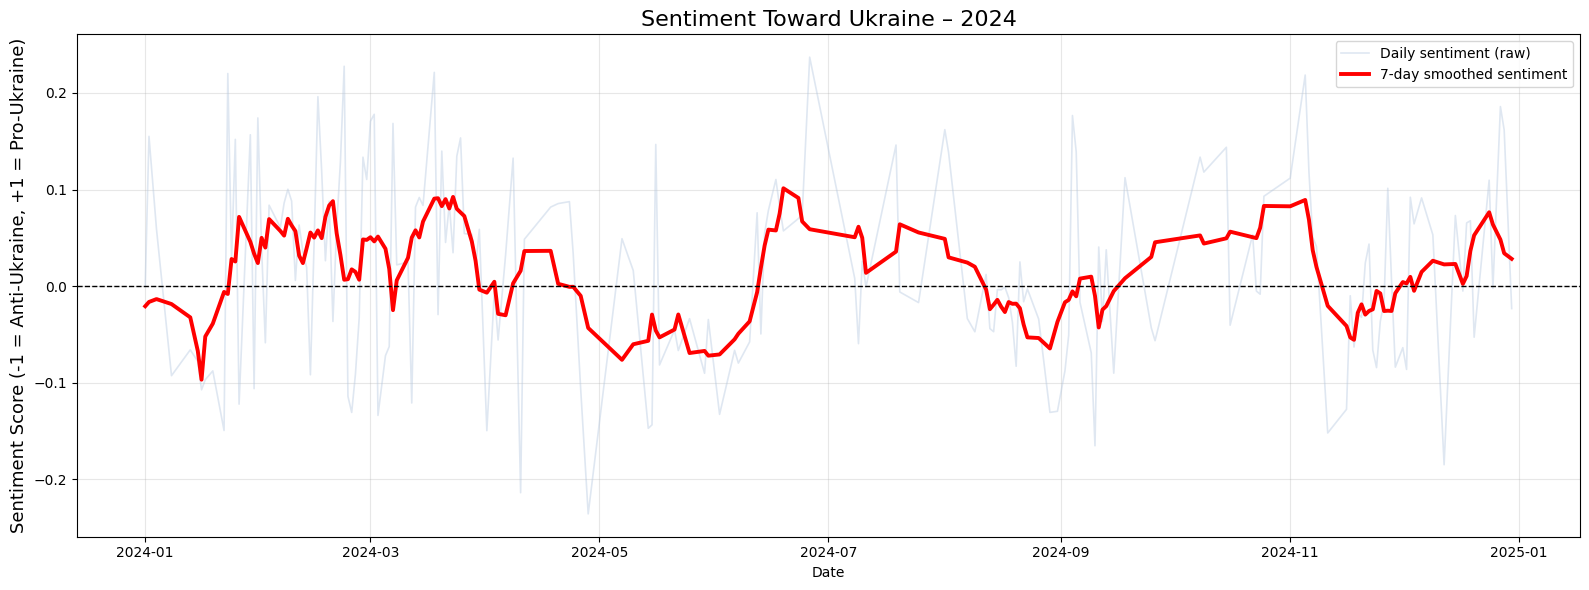

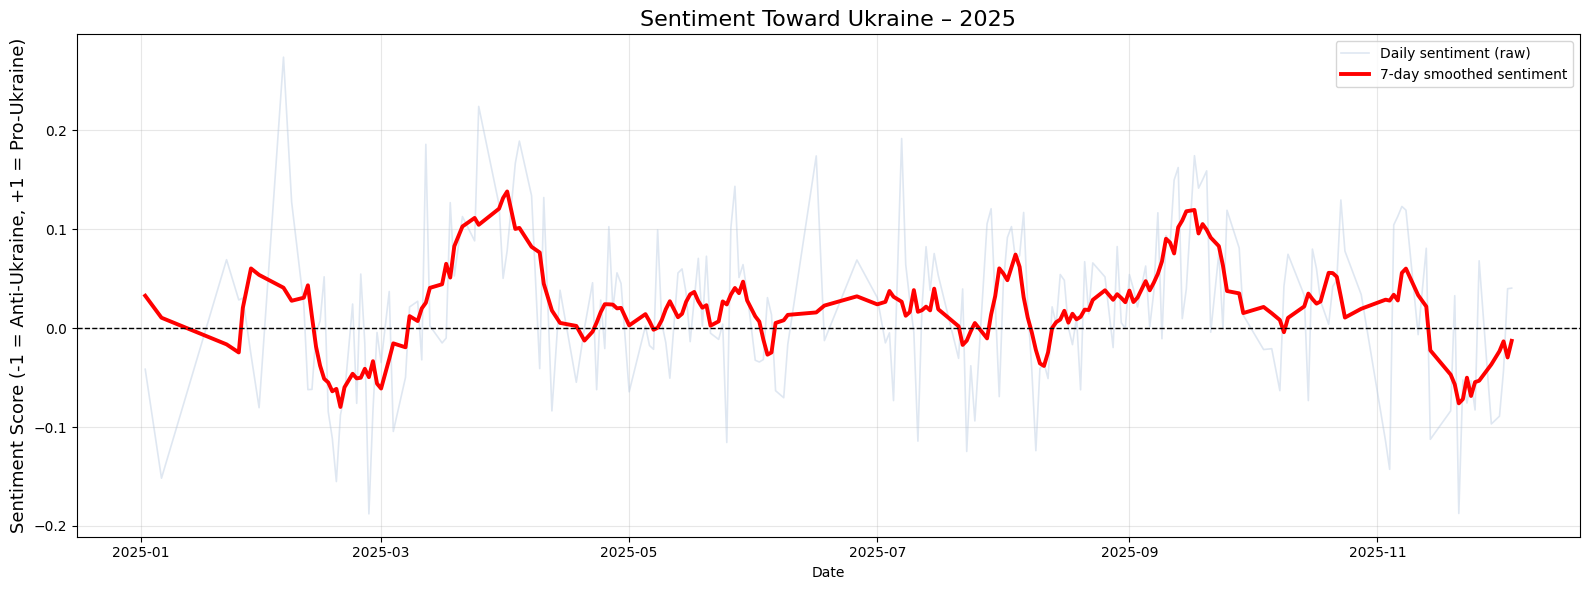

In [10]:
years = sorted(daily["year"].unique())

for year in years:
    df_year = daily[daily["year"] == year]

    if len(df_year) < 30:
        continue

    plt.figure(figsize=(16, 6))

    plt.plot(
        df_year["video_published_at"],
        df_year["daily_sentiment"],
        color="lightsteelblue",
        alpha=0.4,
        linewidth=1.2,
        label="Daily sentiment (raw)"
    )

    plt.plot(
        df_year["video_published_at"],
        df_year["smooth_sentiment"],
        color="red",
        linewidth=2.8,
        label="7-day smoothed sentiment"
    )

    plt.axhline(0, linestyle="--", color="black", linewidth=1)

    plt.title(f"Sentiment Toward Ukraine – {year}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)", fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Extremum detection

In [11]:
def extract_extrema(df_year, order=3):
    values = df_year["smooth_sentiment"].values

    max_idx = argrelextrema(values, np.greater, order=order)[0]
    min_idx = argrelextrema(values, np.less, order=order)[0]

    extrema = []

    for i in max_idx:
        extrema.append({
            "date": df_year.iloc[i]["video_published_at"],
            "sentiment": values[i],
            "type": "max",
            "year": df_year.iloc[i]["year"]
        })

    for i in min_idx:
        extrema.append({
            "date": df_year.iloc[i]["video_published_at"],
            "sentiment": values[i],
            "type": "min",
            "year": df_year.iloc[i]["year"]
        })

    return extrema

all_extrema = []

for year in years:
    df_year = daily[daily["year"] == year].reset_index(drop=True)

    if len(df_year) < 30:
        continue

    all_extrema.extend(extract_extrema(df_year, order=3))

extrema_df = pd.DataFrame(all_extrema).sort_values("date")

In [12]:
extrema_df

,date,sentiment,type,year
24,2023-02-20,-0.019775,min,2023
0,2023-02-24,0.020732,max,2023
25,2023-02-26,-0.011500,min,2023
1,2023-03-01,0.012519,max,2023
26,2023-03-03,-0.021436,min,2023
...,...,...,...,...
99,2025-10-20,0.055848,max,2025
115,2025-10-24,0.010595,min,2025
100,2025-11-08,0.060104,max,2025
116,2025-11-21,-0.076054,min,2025


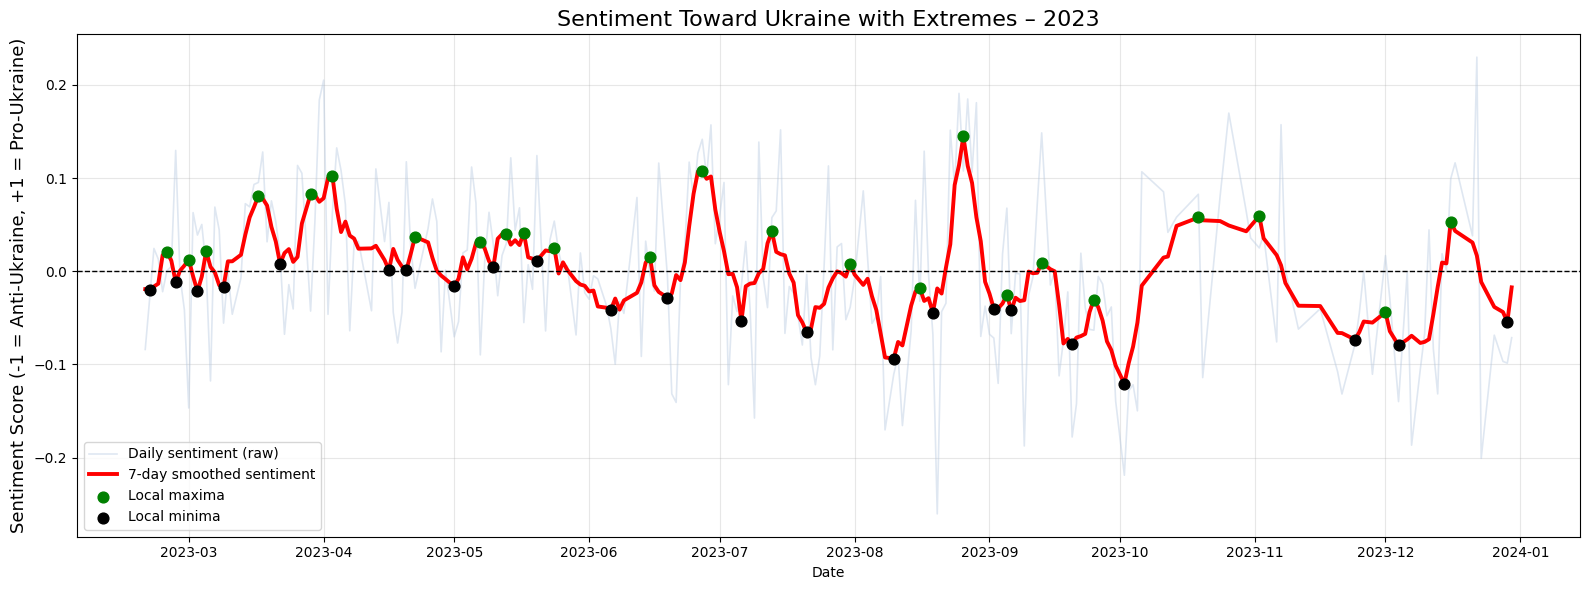

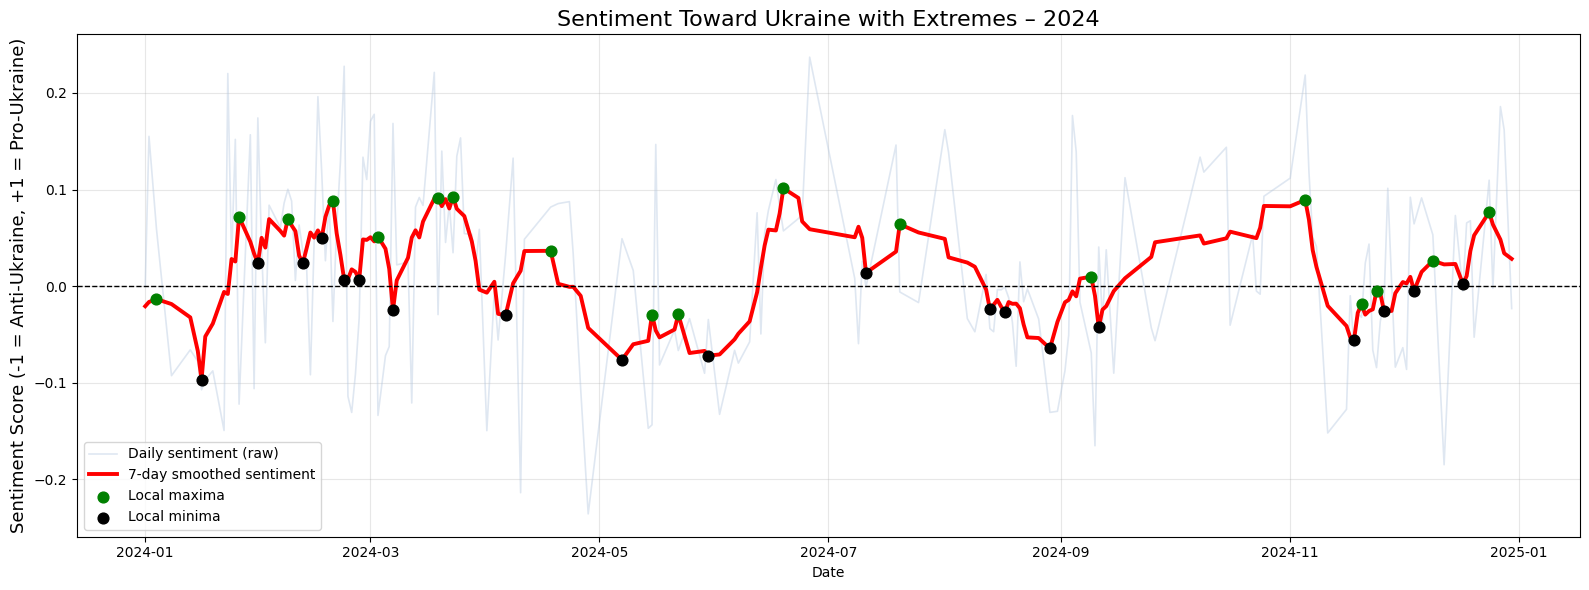

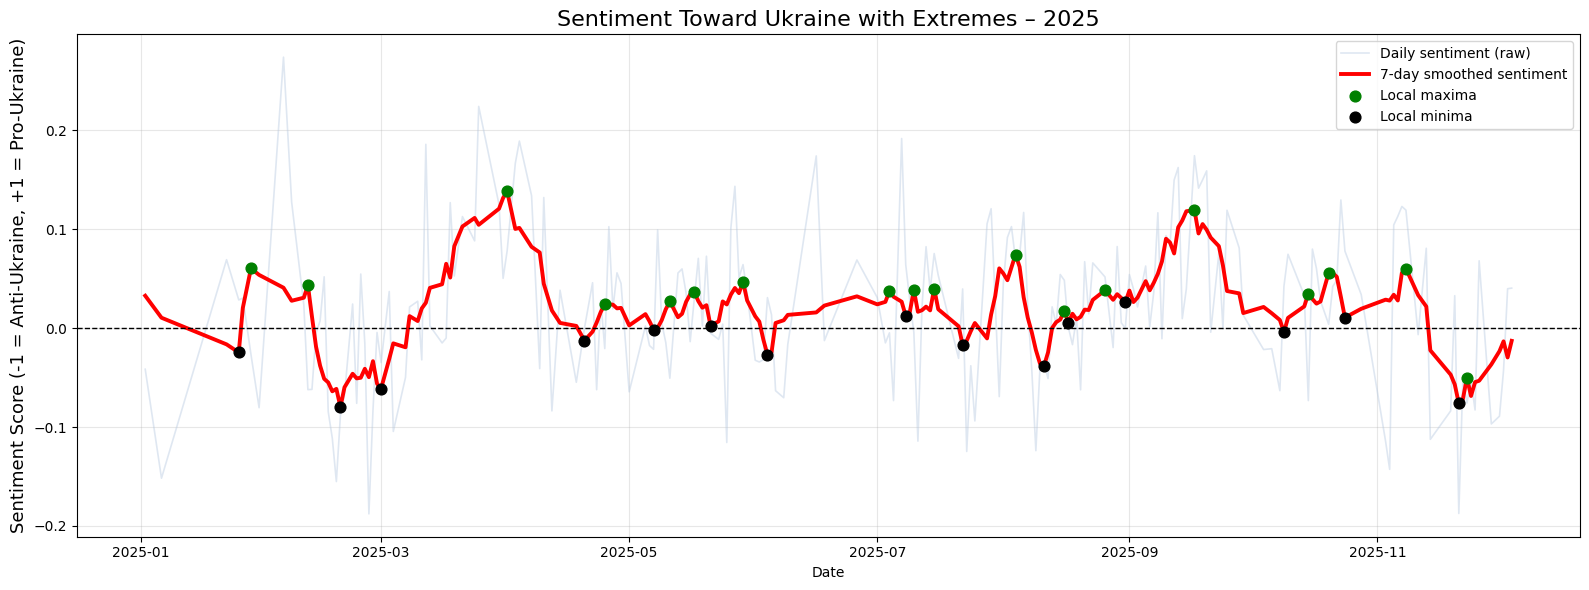

In [13]:
for year in years:
    df_year = daily[daily["year"] == year]
    ext_year = extrema_df[extrema_df["year"] == year]

    if len(df_year) < 30:
        continue

    plt.figure(figsize=(16, 6))

    plt.plot(
        df_year["video_published_at"],
        df_year["daily_sentiment"],
        color="lightsteelblue",
        alpha=0.4,
        linewidth=1.2,
        label="Daily sentiment (raw)"
    )

    plt.plot(
        df_year["video_published_at"],
        df_year["smooth_sentiment"],
        color="red",
        linewidth=2.8,
        label="7-day smoothed sentiment"
    )

    plt.scatter(
        ext_year[ext_year["type"] == "max"]["date"],
        ext_year[ext_year["type"] == "max"]["sentiment"],
        color="green",
        s=60,
        zorder=5,
        label="Local maxima"
    )

    plt.scatter(
        ext_year[ext_year["type"] == "min"]["date"],
        ext_year[ext_year["type"] == "min"]["sentiment"],
        color="black",
        s=60,
        zorder=5,
        label="Local minima"
    )

    plt.axhline(0, linestyle="--", color="black", linewidth=1)

    plt.title(f"Sentiment Toward Ukraine with Extremes – {year}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)", fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
extrema_df.to_csv("sentiment_extrema_by_year.csv", index=False)

print(f"Saved {len(extrema_df)} extrema points to sentiment_extrema_by_year.csv")
print(extrema_df.head())

Saved 117 extrema points to sentiment_extrema_by_year.csv
         date  sentiment type  year
24 2023-02-20  -0.019775  min  2023
0  2023-02-24   0.020732  max  2023
25 2023-02-26  -0.011500  min  2023
1  2023-03-01   0.012519  max  2023
26 2023-03-03  -0.021436  min  2023


#################################################

In [15]:
import pandas as pd

# Load comments
comments = pd.read_csv("comments_with_sentiment.csv")
comments["video_published_at"] = pd.to_datetime(comments["video_published_at"])

# Load extrema
extrema = pd.read_csv("sentiment_extrema_by_year.csv")
extrema["date"] = pd.to_datetime(extrema["date"])

# Normalize to date only (important)
comments["date"] = comments["video_published_at"].dt.date
extrema["date"] = extrema["date"].dt.date

In [16]:
results = []

for _, row in extrema.iterrows():
    extremum_date = row["date"]

    day_comments = comments[comments["date"] == extremum_date]

    if len(day_comments) == 0:
        continue

    # Count comments per video
    video_counts = (
        day_comments
        .groupby(["id", "video_title"])
        .size()
        .reset_index(name="comment_count")
        .sort_values("comment_count", ascending=False)
    )

    # Take top video
    top_video = video_counts.iloc[0]

    results.append({
        "date": extremum_date,
        "year": row["year"],
        "extremum_type": row["type"],
        "sentiment_value": row["sentiment"],
        "video_id": top_video["id"],
        "video_title": top_video["video_title"],
        "comments_on_date": len(day_comments),
        "comments_on_video": top_video["comment_count"],
        "video_share_of_discussion": top_video["comment_count"] / len(day_comments)
    })

In [17]:
attribution_df = pd.DataFrame(results)

attribution_df = attribution_df.sort_values("date")

attribution_df.to_csv(
    "sentiment_extrema_video_attribution.csv",
    index=False
)

print(f"Saved {len(attribution_df)} extrema–video links")
attribution_df.head()

Saved 117 extrema–video links


,date,year,extremum_type,sentiment_value,video_id,video_title,comments_on_date,comments_on_video,video_share_of_discussion
0,2023-02-20,2023,min,-0.019775,Z5OOeAwwOrI,Retired lt. col. thinks Putin may have doubts ...,1394,996,0.714491
1,2023-02-24,2023,max,0.020732,hyn-LzxkpUs,‘Russia has already lost’: US officials lay ou...,8293,2639,0.318220
2,2023-02-26,2023,min,-0.011500,jQjH9qjM5gQ,'Shocking': Reporter says Russian losses are i...,4203,2867,0.682132
3,2023-03-01,2023,max,0.012519,Oe3xtxLek8c,Why a retired major is calling for Ukraine to ...,507,373,0.735700
4,2023-03-03,2023,min,-0.021436,Fwofx9jNS6I,See why a crowd laughed at a top Russian official,7257,5029,0.692986


#####################################################################

In [20]:
events = pd.read_csv("sentiment_extrema_video_attribution.csv")
events["date"] = pd.to_datetime(events["date"])

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=daily["video_published_at"],
    y=daily["daily_sentiment"],
    mode="lines",
    line=dict(color="lightsteelblue", width=1),
    opacity=0.4,
    name="Daily sentiment (raw)"
))

fig.add_trace(go.Scatter(
    x=daily["video_published_at"],
    y=daily["smooth_sentiment"],
    mode="lines",
    line=dict(color="red", width=3),
    name="7-day smoothed sentiment"
))

In [23]:
color_map = {"max": "green", "min": "black"}

for extremum_type in ["max", "min"]:
    subset = events[events["extremum_type"] == extremum_type]

    fig.add_trace(go.Scatter(
        x=subset["date"],
        y=subset["sentiment_value"],
        mode="markers",
        marker=dict(
            size=10,
            color=color_map[extremum_type],
            symbol="circle"
        ),
        name=f"Local {extremum_type}",
        hovertemplate=
            "<b>Date:</b> %{x}<br>" +
            "<b>Sentiment:</b> %{y:.3f}<br>" +
            "<b>Video:</b> %{customdata[0]}<br>" +
            "<b>Comments (video):</b> %{customdata[1]}<br>" +
            "<b>Share of discussion:</b> %{customdata[2]:.1%}<br>" +
            "<extra></extra>",
        customdata=subset[[
            "video_title",
            "comments_on_video",
            "video_share_of_discussion"
        ]]
    ))

In [24]:
fig.update_layout(
    title="Sentiment Toward Ukraine with Dominant Videos at Extremes",
    xaxis_title="Date",
    yaxis_title="Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)",
    template="plotly_white",
    width=1100,
    height=550,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.add_hline(y=0, line_dash="dash", line_color="black")

fig.show()

In [26]:
years = sorted(daily["year"].unique())

color_map = {"max": "green", "min": "black"}

for year in years:
    daily_year = daily[daily["year"] == year]
    events_year = events[events["year"] == year]

    if len(daily_year) < 30:
        continue

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=daily_year["video_published_at"],
        y=daily_year["daily_sentiment"],
        mode="lines",
        line=dict(color="lightsteelblue", width=1),
        opacity=0.4,
        name="Daily sentiment (raw)"
    ))

    fig.add_trace(go.Scatter(
        x=daily_year["video_published_at"],
        y=daily_year["smooth_sentiment"],
        mode="lines",
        line=dict(color="red", width=3),
        name="7-day smoothed sentiment"
    ))

    for extremum_type in ["max", "min"]:
        subset = events_year[events_year["extremum_type"] == extremum_type]

        if subset.empty:
            continue

        fig.add_trace(go.Scatter(
            x=subset["date"],
            y=subset["sentiment_value"],
            mode="markers",
            marker=dict(
                size=10,
                color=color_map[extremum_type]
            ),
            name=f"Local {extremum_type}",
            hovertemplate=
                "<b>Date:</b> %{x}<br>" +
                "<b>Sentiment:</b> %{y:.3f}<br>" +
                "<b>Video:</b> %{customdata[0]}<br>" +
                "<b>Comments (video):</b> %{customdata[1]}<br>" +
                "<b>Share of discussion:</b> %{customdata[2]:.1%}<br>" +
                "<extra></extra>",
            customdata=subset[[
                "video_title",
                "comments_on_video",
                "video_share_of_discussion"
            ]]
        ))

    fig.update_layout(
        title=f"Sentiment Toward Ukraine with Dominant Videos at Extremes — {year}",
        xaxis_title="Date",
        yaxis_title="Sentiment Score (-1 = Anti-Ukraine, +1 = Pro-Ukraine)",
        template="plotly_white",
        width=1100,
        height=550,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.add_hline(y=0, line_dash="dash", line_color="black")

    fig.show()